# Improving performance

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Learning curves

In [3]:
from sklearn.datasets import load_digits

In [4]:
digits = load_digits()

In [5]:
X, y = digits.data, digits.target

In [6]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [7]:
X.shape

(1797, 64)

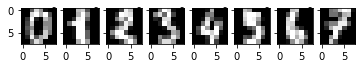

In [8]:
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X.reshape(-1, 8, 8)[i], cmap='gray')

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
K.clear_session()

In [11]:
model = Sequential()
model.add(Dense(16, input_shape=(64,), activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [12]:
# store the initial random weights
initial_weights = model.get_weights()

In [13]:
y_cat = to_categorical(y, 10)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat,
                                                    test_size=0.3)

In [16]:
X_train.shape

(1257, 64)

In [17]:
train_sizes = (len(X_train) * np.linspace(0.1, 0.999, 4)).astype(int)
train_sizes

array([ 125,  502,  879, 1255])

In [19]:
train_scores = []
test_scores = []

for train_size in train_sizes:
    X_train_frac, _, y_train_frac, _ = \
    train_test_split(X_train, y_train, train_size=train_size)
    
    # at each iteration reset the weights of the model
    # to the initial random weights
    model.set_weights(initial_weights)
    
    h = model.fit(X_train_frac, y_train_frac,
                  verbose=0,
                  epochs=300,
                  callbacks=[EarlyStopping(monitor='loss', patience=1)])

    r = model.evaluate(X_train_frac, y_train_frac, verbose=0)
    train_scores.append(r[-1])
    
    e = model.evaluate(X_test, y_test, verbose=0)
    test_scores.append(e[-1])
    
    print("Done size: ", train_size)

Done size:  125
Done size:  502
Done size:  879
Done size:  1255


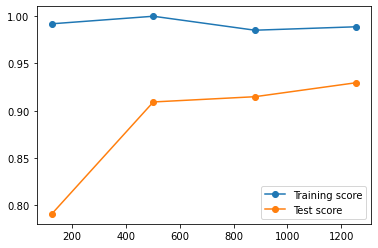

In [20]:
plt.plot(train_sizes, train_scores, 'o-', label="Training score")
plt.plot(train_sizes, test_scores, 'o-', label="Test score")
plt.legend(loc="best")

## Batch Normalization

In [22]:
from tensorflow.keras.layers import BatchNormalization

In [23]:
def repeated_training(X_train,
                      y_train,
                      X_test,
                      y_test,
                      units=512,
                      activation='sigmoid',
                      optimizer='sgd',
                      do_bn=False,
                      epochs=10,
                      repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        activation=activation))
        if do_bn:
            model.add(BatchNormalization())

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=epochs,
                      verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [24]:
mean_acc, std_acc, mean_acc_val, std_acc_val = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=False)

0 1 2 


In [25]:
mean_acc_bn, std_acc_bn, mean_acc_val_bn, std_acc_val_bn = \
    repeated_training(X_train, y_train, X_test, y_test, do_bn=True)

0 1 2 


In [26]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

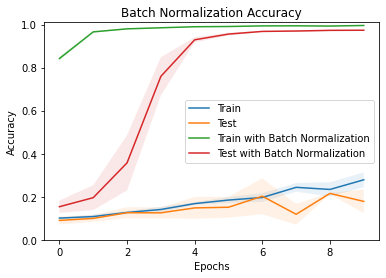

In [28]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_bn, std_acc_bn)
plot_mean_std(mean_acc_val_bn, std_acc_val_bn)
plt.ylim(0, 1.01)
plt.title("Batch Normalization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best');

## Weight Regularization & Dropout

In [30]:
from tensorflow.keras.layers import Dropout

In [31]:
model = Sequential()
model.add(Dropout(0.2, input_shape=X_train.shape[1:]))
# first fully connected layer
model.add(Dense(512, kernel_initializer='normal',
                kernel_regularizer='l2', activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile('sgd',
              'categorical_crossentropy',
              metrics=['accuracy'])

## Data augmentation

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 20,
                               shear_range = 0.3,
                               zoom_range = 0.3,
                               horizontal_flip = True)

In [35]:
train = generator.flow_from_directory('C:/Users/aloke/OneDrive/Pictures/',
                                      target_size = (128, 128),
                                      batch_size = 32,
                                      class_mode = 'binary')

Found 1 images belonging to 3 classes.


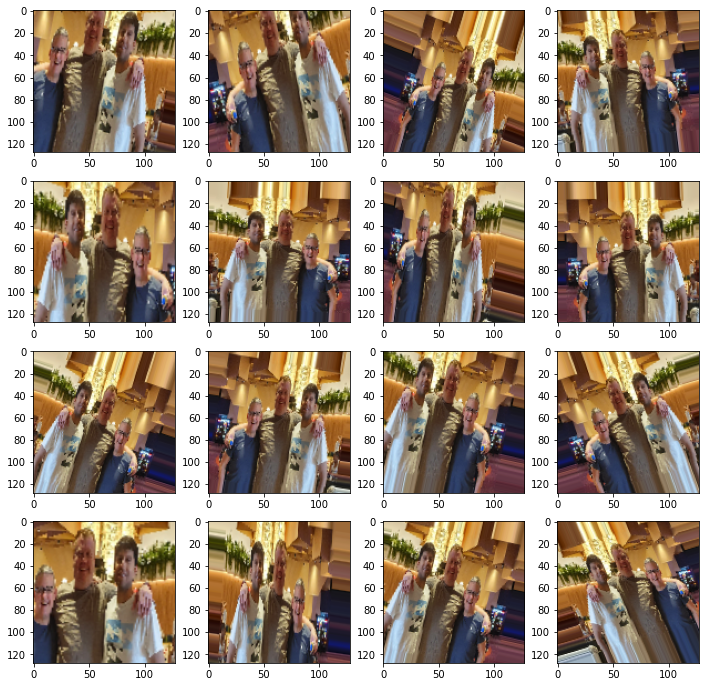

In [36]:
plt.figure(figsize=(12, 12))
for i in range(16):
    img, label = train.next()
    plt.subplot(4, 4, i+1)
    plt.imshow(img[0])

## Embeddings

In [38]:
from tensorflow.keras.layers import Embedding

In [39]:
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=2))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 2)           200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [41]:
emb = model.predict(np.array([[81,  1, 96, 79],
                              [17, 47, 69, 50],
                              [49,  3, 12, 88]]))

In [42]:
emb.shape

(3, 4, 2)

In [43]:
emb

array([[[ 0.02355367, -0.01773329],
        [ 0.03563536,  0.03672545],
        [ 0.01675061, -0.01300381],
        [ 0.01804979,  0.03933059]],

       [[ 0.0374007 , -0.03072958],
        [-0.04799324, -0.02926478],
        [-0.03001151, -0.04508073],
        [-0.04933808, -0.04356486]],

       [[-0.0380471 ,  0.02601638],
        [ 0.04052906,  0.02867018],
        [ 0.00735705, -0.03864782],
        [ 0.04101718, -0.00816602]]], dtype=float32)

## Sentiment prediction on movie Reviews

In [44]:
from tensorflow.keras.datasets import imdb

In [45]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

17473536/17464789 [==============================] - 3s 0us/step


In [46]:
X_train.shape

(25000,)

In [47]:
X_train[1]

[1,
 194,
 1153,
 194,
 8255,
 78,
 228,
 5,
 6,
 1463,
 4369,
 5012,
 134,
 26,
 4,
 715,
 8,
 118,
 1634,
 14,
 394,
 20,
 13,
 119,
 954,
 189,
 102,
 5,
 207,
 110,
 3103,
 21,
 14,
 69,
 188,
 8,
 30,
 23,
 7,
 4,
 249,
 126,
 93,
 4,
 114,
 9,
 2300,
 1523,
 5,
 647,
 4,
 116,
 9,
 35,
 8163,
 4,
 229,
 9,
 340,
 1322,
 4,
 118,
 9,
 4,
 130,
 4901,
 19,
 4,
 1002,
 5,
 89,
 29,
 952,
 46,
 37,
 4,
 455,
 9,
 45,
 43,
 38,
 1543,
 1905,
 398,
 4,
 1649,
 26,
 6853,
 5,
 163,
 11,
 3215,
 10156,
 4,
 1153,
 9,
 194,
 775,
 7,
 8255,
 11596,
 349,
 2637,
 148,
 605,
 15358,
 8003,
 15,
 123,
 125,
 68,
 23141,
 6853,
 15,
 349,
 165,
 4362,
 98,
 5,
 4,
 228,
 9,
 43,
 36893,
 1157,
 15,
 299,
 120,
 5,
 120,
 174,
 11,
 220,
 175,
 136,
 50,
 9,
 4373,
 228,
 8255,
 5,
 25249,
 656,
 245,
 2350,
 5,
 4,
 9837,
 131,
 152,
 491,
 18,
 46151,
 32,
 7464,
 1212,
 14,
 9,
 6,
 371,
 78,
 22,
 625,
 64,
 1382,
 9,
 8,
 168,
 145,
 23,
 4,
 1690,
 15,
 16,
 4,
 1355,
 5,
 28,
 6,
 52,
 

In [48]:
idx = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [49]:
max(idx.values())

88584

In [50]:
idx

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [51]:
rev_idx = {v+3:k for k,v in idx.items()}

In [52]:
rev_idx

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

In [53]:
rev_idx[0] = 'padding_char'
rev_idx[1] = 'start_char'
rev_idx[2] = 'oov_char'
rev_idx[3] = 'unk_char'

In [54]:
rev_idx[3]

'unk_char'

In [55]:
y_train[0]

1

In [56]:
example_review = ' '.join([rev_idx[word] for word in X_train[0]])
example_review

"start_char this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and

In [57]:
len(X_train[0])

218

In [58]:
len(X_train[1])

189

In [59]:
len(X_train[2])

141

In [60]:
len(X_train[3])

550

In [61]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM

In [62]:
maxlen = 100

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

In [63]:
X_train_pad.shape

(25000, 100)

In [64]:
X_train_pad[0]

array([ 1415,    33,     6,    22,    12,   215,    28,    77,    52,
           5,    14,   407,    16,    82, 10311,     8,     4,   107,
         117,  5952,    15,   256,     4, 31050,     7,  3766,     5,
         723,    36,    71,    43,   530,   476,    26,   400,   317,
          46,     7,     4, 12118,  1029,    13,   104,    88,     4,
         381,    15,   297,    98,    32,  2071,    56,    26,   141,
           6,   194,  7486,    18,     4,   226,    22,    21,   134,
         476,    26,   480,     5,   144,    30,  5535,    18,    51,
          36,    28,   224,    92,    25,   104,     4,   226,    65,
          16,    38,  1334,    88,    12,    16,   283,     5,    16,
        4472,   113,   103,    32,    15,    16,  5345,    19,   178,
          32])

In [65]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 22665,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 21631,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 31050,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5

In [66]:
max_features = max([max(x) for x in X_train_pad] + 
                   [max(x) for x in X_test_pad]) + 1
max_features

88587

In [67]:
y_train

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [68]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [69]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Epoch 1/2
547/547 [==============================] - 98s 177ms/step - loss: 0.4352 - accuracy: 0.7934 - val_loss: 0.3428 - val_accuracy: 0.8539
Epoch 2/2
547/547 [==============================] - 104s 190ms/step - loss: 0.2028 - accuracy: 0.9238 - val_loss: 0.3823 - val_accuracy: 0.8491


In [70]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 6s 8ms/step - loss: 0.3999 - accuracy: 0.8402
Test score: 0.39986085891723633
Test accuracy: 0.8402000069618225


## Exercise 1

In [93]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [94]:
max_features = 20000
skip_top = 200

In [95]:
(X_train, y_train), (X_test, y_test) = imdb.load_data('/tmp/imdb.npz',
                                                      num_words=max_features,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [96]:
X_train.shape

(25000,)

In [97]:
maxlen = 80

In [98]:
X_train_pad = pad_sequences(X_train, maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=maxlen, truncating='post')

In [99]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [100]:
X_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

In [101]:
model.fit(X_train_pad, y_train,
          batch_size=32,
          epochs=2,
          validation_split=0.3)

Epoch 1/2
547/547 [==============================] - 34s 59ms/step - loss: 0.5050 - accuracy: 0.7554 - val_loss: 0.4256 - val_accuracy: 0.8180
Epoch 2/2
547/547 [==============================] - 33s 60ms/step - loss: 0.3061 - accuracy: 0.8766 - val_loss: 0.4408 - val_accuracy: 0.8140


In [102]:
score, acc = model.evaluate(X_test_pad, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 6s 7ms/step - loss: 0.5087 - accuracy: 0.7891
Test score: 0.5086826086044312
Test accuracy: 0.789080023765564


## Exercise 2

In [104]:
from sklearn.datasets import load_digits
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
import tensorflow.keras.backend as K

In [105]:
digits = load_digits()
X, y = digits.data, digits.target
y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3)

In [106]:
def repeated_training_reg_dropout(X_train,
                                  y_train,
                                  X_test,
                                  y_test,
                                  units=512,
                                  activation='sigmoid',
                                  optimizer='sgd',
                                  do_dropout=False,
                                  rate=0.3,
                                  kernel_regularizer='l2',
                                  epochs=10,
                                  repeats=3):
    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])

        h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, verbose=0)
        histories.append([h.history['accuracy'], h.history['val_accuracy']])
        print(repeat, end=' ')

    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [107]:
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training_reg_dropout(X_train,
                                                                             y_train,
                                                                             X_test,
                                                                             y_test,
                                                                             do_dropout=False)

0 1 2 


In [108]:
mean_acc_do, std_acc_do, mean_acc_val_do, std_acc_val_do = repeated_training_reg_dropout(X_train,
                                                                                         y_train,
                                                                                         X_test,
                                                                                         y_test,
                                                                                         do_dropout=True)

0 1 2 


In [109]:
def plot_mean_std(m, s):
    plt.plot(m)
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)

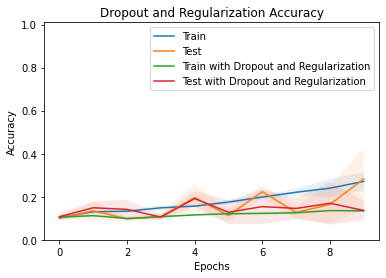

In [110]:
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)
plot_mean_std(mean_acc_do, std_acc_do)
plot_mean_std(mean_acc_val_do, std_acc_val_do)
plt.ylim(0, 1.01)
plt.title("Dropout and Regularization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Dropout and Regularization', 'Test with Dropout and Regularization'], loc='best')

## Exercise 3

In [142]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from itertools import islice
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [116]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [117]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        3

In [121]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)